In [1]:
import torch
import numpy as np
from model.models import UNet, UNetAttention
from data.data import InvERTDataset
from pathlib import Path
from json5 import load as json_load
import simpeg
from simpeg.electromagnetics.static import resistivity as dc
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)
from discretize import TensorMesh
from discretize.utils import active_from_xyz
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.axes._axes import Axes
from matplotlib.colors import LogNorm, Normalize

In [2]:
def detransform(log_res: float | np.ndarray[float]) -> float | np.ndarray[float]:
    return 2 * 10 ** (4 * log_res)

In [3]:
experiment_path = Path("/home/labo3A/results/resized_24-04-2025_16h21")

In [4]:
class Transform:
    def __init__(self):
        pass

    def __call__(self, sample):
        sample['pseudosection'] = sample['pseudosection'].unsqueeze(0)

        pseudosection = sample['pseudosection']
        num_electrode_channel = torch.ones_like(pseudosection) * sample['num_electrode']
        subsection_length_channel = torch.ones_like(pseudosection) * sample['subsection_length']
        array_type_channel = sample['array_type']
        array_type_channel = array_type_channel.view(-1, 1, 1).expand(-1, pseudosection.shape[1], pseudosection.shape[2])
        sample['pseudosection'] = torch.cat((pseudosection, num_electrode_channel, subsection_length_channel, array_type_channel), dim=0)
        
        sample['norm_log_resistivity_model'] = sample['norm_log_resistivity_model'].unsqueeze(0)
        sample['JtJ_diag'] = sample['JtJ_diag'].unsqueeze(0)
        # sample['JtJ_diag'] = torch.ones_like(sample['JtJ_diag'])
        
        return sample

In [5]:
with open(experiment_path / 'config.json5', mode='r', encoding="utf8") as config_file:
    config_dict = json_load(config_file)

dataset = InvERTDataset(
    Path(config_dict['dataset']['dataset_name']),
    transform=Transform(),
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

DATASET: Found 24556 samples in /home/labo3A/samples_normalized_ps_resized.


In [6]:
model_ckpt_path = experiment_path / "figures/model_output/checkpoints"
model_ckpt_list = sorted(model_ckpt_path.glob("*.pth"), key=lambda x: int(x.stem.split("_")[-1]))
print(f"Found {len(model_ckpt_list)} checkpoints, last one is {model_ckpt_list[-1].stem}")

Found 39 checkpoints, last one is model_epoch_39


In [7]:
model = UNet()
model.load_state_dict(torch.load(model_ckpt_list[-1], map_location='cpu')['model_state_dict'])
model.eval()

UNet(
  (downs): ModuleList(
    (0): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(5, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=

In [8]:
sample = next(iter(dataloader))
while int(sample['num_electrode'] * 72 + 24) > 40 or sample['array_type'][0, 0] == 1:
    sample = next(iter(dataloader))

num_electrodes = int(sample['num_electrode'] * 72 + 24)
array_type = sample['array_type']
pseudosection = sample['pseudosection']
norm_log_resistivity_model = sample['norm_log_resistivity_model']
JtJ_diag = sample['JtJ_diag']

print(f"num_electrodes: {num_electrodes}")
print(f"array_type: {array_type}")
print(f"pseudosection.shape: {pseudosection.shape}")
print(f"norm_log_resistivity_model.shape: {norm_log_resistivity_model.shape}")
print(f"JtJ_diag.shape: {JtJ_diag.shape}")

num_electrodes: 29
array_type: tensor([[0, 1]], dtype=torch.int32)
pseudosection.shape: torch.Size([1, 5, 49, 93])
norm_log_resistivity_model.shape: torch.Size([1, 1, 192, 256])
JtJ_diag.shape: torch.Size([1, 1, 192, 256])


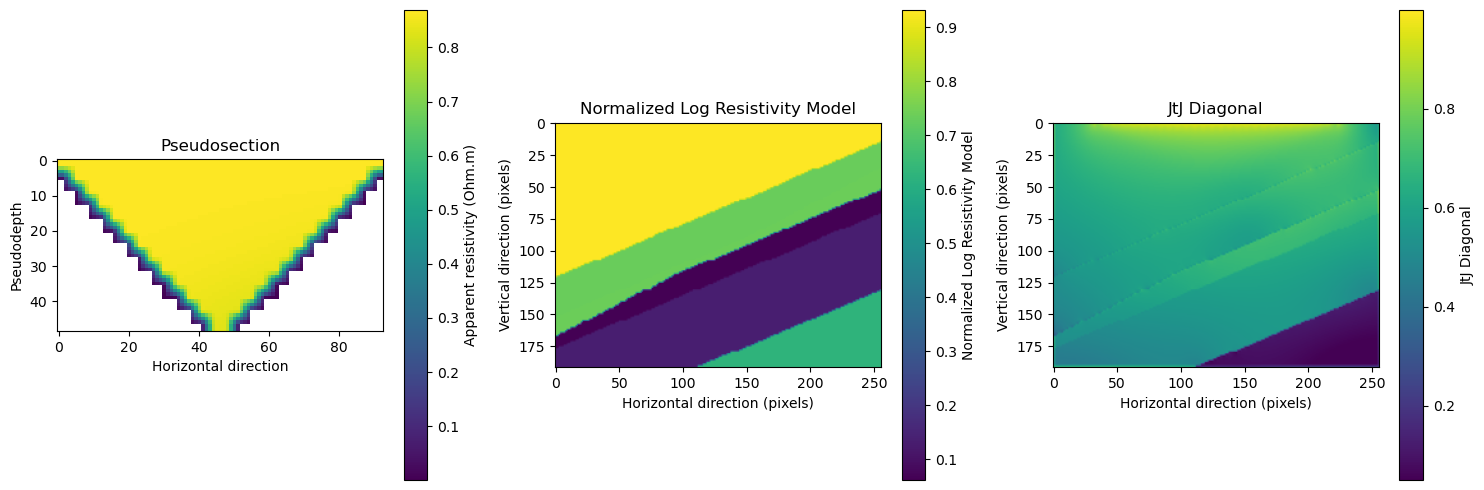

In [9]:
pseudosection_only = pseudosection[:, 0].squeeze().detach().cpu().numpy().copy()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

pseudosection_only[pseudosection_only == 0] = np.nan
vmin = np.nanmin(pseudosection_only)
vmax = np.nanmax(pseudosection_only)
im0 = axes[0].imshow(pseudosection_only, cmap='viridis', norm=Normalize(vmin=vmin, vmax=vmax))
axes[0].set_title("Pseudosection")
axes[0].set_xlabel("Horizontal direction")
axes[0].set_ylabel("Pseudodepth")
cbar = fig.colorbar(im0, ax=axes[0], orientation='vertical')
cbar.set_label("Apparent resistivity (Ohm.m)")

im1 = axes[1].imshow(norm_log_resistivity_model.squeeze(), cmap='viridis')
axes[1].set_title("Normalized Log Resistivity Model")
axes[1].set_xlabel("Horizontal direction (pixels)")
axes[1].set_ylabel("Vertical direction (pixels)")
cbar = fig.colorbar(im1, ax=axes[1], orientation='vertical')
cbar.set_label("Normalized Log Resistivity Model")

im2 = axes[2].imshow(JtJ_diag.squeeze(), cmap='viridis')
axes[2].set_title("JtJ Diagonal")
axes[2].set_xlabel("Horizontal direction (pixels)")
axes[2].set_ylabel("Vertical direction (pixels)")
cbar = fig.colorbar(im2, ax=axes[2], orientation='vertical')
cbar.set_label("JtJ Diagonal")
plt.tight_layout()
plt.show()

In [10]:
space_between_electrodes = 5
lateral_padding = 5
vertical_fraction = 0.75

lateral_padding = space_between_electrodes * lateral_padding
total_pixels_after_refinement = (num_electrodes - 1) * space_between_electrodes + 2 * lateral_padding
vertical_size = int(total_pixels_after_refinement * vertical_fraction)

total_pixels_after_refinement = 256
vertical_size = 192

assert norm_log_resistivity_model.squeeze().shape == (vertical_size, total_pixels_after_refinement), f"Shape mismatch between resistivity model ({norm_log_resistivity_model.squeeze().shape}) and calculated size ({(vertical_size, total_pixels_after_refinement)})"

In [11]:
def schlumberger_array(nbr_electrodes: int,
                       electrode_locations: np.ndarray[np.float64],
                       data_type: str
                       ) -> list[dc.sources.Dipole]:
    source_list = []
    for a in range(1, nbr_electrodes // 2):
        locations_a = electrode_locations[:(-2 * a) - 1]
        locations_b = electrode_locations[(2 * a) + 1:]
        locations_m = electrode_locations[a:-a - 1]
        locations_n = electrode_locations[a + 1:-a]
        receivers_list_a = [
            dc.receivers.Dipole(locations_m=loc_m, locations_n=loc_n, data_type=data_type)
            for loc_m, loc_n in zip(locations_m, locations_n)
        ]
        source_list_a = [
            dc.sources.Dipole(
                receiver_list_a, location_a=loc_a, location_b=loc_b
            )
            for receiver_list_a, loc_a, loc_b in zip(receivers_list_a, locations_a, locations_b)
        ]
        source_list += source_list_a
    return source_list

def wenner_array(nbr_electrodes: int,
                 electrode_locations: np.ndarray[np.float64],
                 data_type: str
                 ) -> list[dc.sources.Dipole]:
    source_list = []
    for a in range(1, (nbr_electrodes + 3) // 3 + 1):
        locations_a = electrode_locations[:-3 * a:]
        locations_b = electrode_locations[3 * a:]
        locations_m = electrode_locations[a:-2 * a:]
        locations_n = electrode_locations[2 * a:-a]
        receivers_list_a = [
            dc.receivers.Dipole(locations_m=loc_m, locations_n=loc_n, data_type=data_type)
            for loc_m, loc_n in zip(locations_m, locations_n)
        ]
        source_list_a = [
            dc.sources.Dipole(
                receiver_list_a, location_a=loc_a, location_b=loc_b
            )
            for receiver_list_a, loc_a, loc_b in zip(receivers_list_a, locations_a, locations_b)
        ]

        source_list += source_list_a
    return source_list


x_topo = np.linspace(lateral_padding, total_pixels_after_refinement - lateral_padding, total_pixels_after_refinement)
z_topo = np.zeros_like(x_topo)
topo_2d = np.c_[x_topo, z_topo]
electrode_locations_x = np.linspace(lateral_padding, total_pixels_after_refinement - lateral_padding, num_electrodes)
electrode_locations_z = np.zeros_like(electrode_locations_x)
electrode_locations = np.c_[electrode_locations_x, electrode_locations_z]
array = wenner_array if array_type.squeeze()[0] else schlumberger_array
source_list = array(num_electrodes, electrode_locations, "apparent_resistivity")
survey = dc.Survey(source_list)
hx = [(1, total_pixels_after_refinement)]
hz = [(1, vertical_size)]
mesh = TensorMesh((hx, hz), origin="0N")
active_cells = active_from_xyz(mesh, topo_2d)
log_resistivity_map = maps.IdentityMap(mesh) * maps.ExpMap(mesh)
survey.drape_electrodes_on_topography(mesh, active_cells, option="top", topography=topo_2d)
_ = survey.set_geometric_factor()

In [12]:
pseudosection_np = pseudosection[:, 0].squeeze().numpy()
flatten_pseudosection = pseudosection_np.flatten()
apparent_resistivities = flatten_pseudosection[flatten_pseudosection != 0]
apparent_resistivities = np.exp(apparent_resistivities * (10.5725765 - 0))

In [13]:
print(len(apparent_resistivities))
print(f"min apparent resistivity: {np.min(apparent_resistivities)}")
print(f"max apparent resistivity: {np.max(apparent_resistivities)}")

2761
min apparent resistivity: 1.0048738718032837
max apparent resistivity: 9795.451171875


In [14]:
resistivity_data = data.Data(survey=survey, dobs=apparent_resistivities)
resistivity_data.standard_deviation = 1e-7 + 0.05 * np.abs(resistivity_data.dobs)
print(f"min standard deviation: {np.min(resistivity_data.standard_deviation)}")
print(f"max standard deviation: {np.max(resistivity_data.standard_deviation)}")

ValueError: 'dobs' must be (np.int64(182),), got (2761,)

In [ ]:
median_resistivity = np.median(apparent_resistivities)
starting_log_resistivity_model = np.log(median_resistivity) * np.ones(sum(active_cells))
reference_log_resistivity_model = starting_log_resistivity_model.copy()

In [ ]:
resistivity_simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=resistivity_data.survey, rhoMap=log_resistivity_map, storeJ=True, nky=5
)

dmis_L2 = data_misfit.L2DataMisfit(simulation=resistivity_simulation, data=resistivity_data)

reg_L2 = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_cells,
    mapping=maps.IdentityMap(nP=sum(active_cells)),
    reference_model=reference_log_resistivity_model,
)

opt_L2 = optimization.InexactGaussNewton(
    maxIter=10,
    maxIterLS=10,
    maxIterCG=5,
    tolCG=1e-5
)

inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

update_jacobi = directives.UpdatePreconditioner(update_every_iteration=False)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
target_misfit = directives.TargetMisfit(chifact=2.0)

directives_list_L2 = [
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
]

inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

In [ ]:
# Run the inversion
recovered_log_resistivity_model = inv_L2.run(starting_log_resistivity_model)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


/root/miniconda3/envs/simPEG/lib/python3.13/site-packages/simpeg/simulation.py:197: DefaultSolverWarning: Using the default solver: Pardiso. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)
/root/miniconda3/envs/simPEG/lib/python3.13/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.36e+02  4.26e+04  0.00e+00  4.26e+04    3.49e+03      0              
   1  1.36e+02  2.59e+04  5.09e+01  3.28e+04    5.50e+02      0              
   2  1.36e+02  2.68e+04  4.27e+01  3.26e+04    2.94e+02      0              
   3  6.78e+01  2.63e+04  4.57e+01  2.94e+04    9.51e+02      0              
   4  6.78e+01  2.04e+04  1.11e+02  2.79e+04    1.51e+02      0              
   5  6.78e+01  2.09e+04  1.03e+02  2.79e+04    7.56e+01      0              
   6  3.39e+01  2.07e+04  1.05e+02  2.43e+04    7.34e+02      0              
   7  3.39e+01  1.49e+04  2.30e+02  2.27e+04    1.08e+02      0              
   8  3.39e+01  1.49e+04  2.28e+02  2.27e+04    9.25e+01      3              
------------------------

In [ ]:
recovered_resistivity_model = np.exp(recovered_log_resistivity_model)

In [ ]:
output = model(pseudosection, norm_log_resistivity_model)
output = output.squeeze().detach().numpy()

dnn_resistivity_model = detransform(output)

RuntimeError: Calculated padded input size per channel: (3 x 11). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

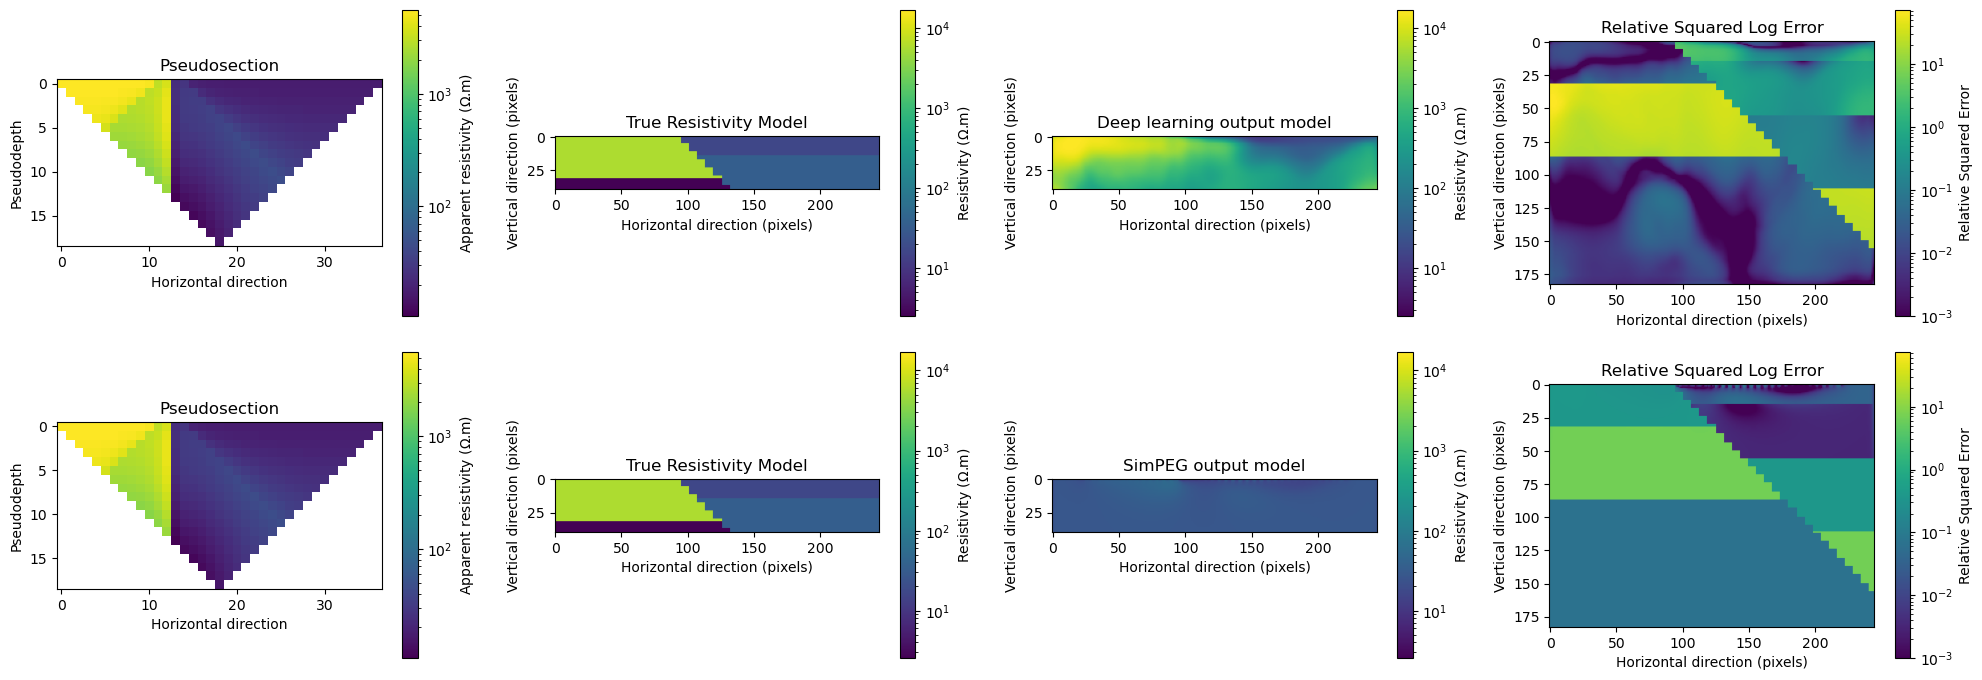

Total dnn resistivity model error: 280118.59, mean: 6.25, max: 72.70
Total simPEG resistivity model error: 66886.83, mean: 1.49, max: 6.92


In [ ]:
depth_slice = slice(0, 40)

true_resistivity_model = detransform(norm_log_resistivity_model.squeeze().numpy())

pseudosection_np = pseudosection[:, 0].squeeze().numpy()
pseudosection_np = np.exp(pseudosection_np * (10.5725765 - 0))
pseudosection_np = np.where(pseudosection_np != 1, pseudosection_np, np.nan)

psed_min = np.nanmin(pseudosection_np)
psed_max = np.nanmax(pseudosection_np)
psed_norm = mcolors.LogNorm(vmin=psed_min, vmax=psed_max)

simPEG_resistivity_model = np.flipud(recovered_resistivity_model.reshape(true_resistivity_model.shape))

squared_error_dnn = np.square(np.log(dnn_resistivity_model) - np.log(true_resistivity_model)) / np.log(true_resistivity_model) ** 2
squared_error_simPEG = np.square(np.log(simPEG_resistivity_model) - np.log(true_resistivity_model)) / np.log(true_resistivity_model) ** 2
error_vmin = min(np.min(squared_error_dnn), np.min(squared_error_simPEG))
error_vmax = max(np.max(squared_error_dnn), np.max(squared_error_simPEG))
# error_norm = mcolors.LogNorm(vmin=error_vmin, vmax=error_vmax)
error_norm = mcolors.LogNorm(vmin=1e-3, vmax=error_vmax)

vmin = min(np.min(dnn_resistivity_model), np.min(simPEG_resistivity_model), np.min(true_resistivity_model))
vmax = max(np.max(dnn_resistivity_model), np.max(simPEG_resistivity_model), np.max(true_resistivity_model))
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)


fig, axes = plt.subplots(2, 4, figsize=(20, 7))
im0 = axes[0, 0].imshow(pseudosection_np, cmap='viridis', norm=psed_norm)
axes[0, 0].set_title("Pseudosection")
axes[0, 0].set_xlabel("Horizontal direction")
axes[0, 0].set_ylabel("Pseudodepth")

# Set the color for values below the minimum
cbar = fig.colorbar(im0, ax=axes[0, 0], orientation='vertical')
cbar.set_label(r"Apparent resistivity ($\Omega$.m)")

im1 = axes[0, 1].imshow(true_resistivity_model[depth_slice, :], cmap='viridis', norm=norm)
axes[0, 1].set_title("True Resistivity Model")
axes[0, 1].set_xlabel("Horizontal direction (pixels)")
axes[0, 1].set_ylabel("Vertical direction (pixels)")
cbar = fig.colorbar(im1, ax=axes[0, 1], orientation='vertical')
cbar.set_label(r"Resistivity ($\Omega$.m)")

im2 = axes[0, 2].imshow(dnn_resistivity_model[depth_slice, :], cmap='viridis', norm=norm)
axes[0, 2].set_title("Deep learning output model")
axes[0, 2].set_xlabel("Horizontal direction (pixels)")
axes[0, 2].set_ylabel("Vertical direction (pixels)")
cbar = fig.colorbar(im2, ax=axes[0, 2], orientation='vertical')
cbar.set_label(r"Resistivity ($\Omega$.m)")


im3 = axes[0, 3].imshow(squared_error_dnn, cmap='viridis', norm=error_norm)
axes[0, 3].set_title("Relative Squared Log Error")
axes[0, 3].set_xlabel("Horizontal direction (pixels)")
axes[0, 3].set_ylabel("Vertical direction (pixels)")
cbar = fig.colorbar(im3, ax=axes[0, 3], orientation='vertical')
cbar.set_label("Relative Squared Error")


im4 = axes[1, 0].imshow(pseudosection_np, cmap='viridis', norm=psed_norm)
axes[1, 0].set_title("Pseudosection")
axes[1, 0].set_xlabel("Horizontal direction")
axes[1, 0].set_ylabel("Pseudodepth")
cbar = fig.colorbar(im4, ax=axes[1, 0], orientation='vertical')
cbar.set_label(r"Apparent resistivity ($\Omega$.m)")

im5 = axes[1, 1].imshow(true_resistivity_model[depth_slice, :], cmap='viridis', norm=norm)
axes[1, 1].set_title("True Resistivity Model")
axes[1, 1].set_xlabel("Horizontal direction (pixels)")
axes[1, 1].set_ylabel("Vertical direction (pixels)")
cbar = fig.colorbar(im5, ax=axes[1, 1], orientation='vertical')
cbar.set_label(r"Resistivity ($\Omega$.m)")

im6 = axes[1, 2].imshow(simPEG_resistivity_model[depth_slice, :], cmap='viridis', norm=norm)
axes[1, 2].set_title("SimPEG output model")
axes[1, 2].set_xlabel("Horizontal direction (pixels)")
axes[1, 2].set_ylabel("Vertical direction (pixels)")
cbar = fig.colorbar(im6, ax=axes[1, 2], orientation='vertical')
cbar.set_label(r"Resistivity ($\Omega$.m)")

im7 = axes[1, 3].imshow(squared_error_simPEG, cmap='viridis', norm=error_norm)
axes[1, 3].set_title("Relative Squared Log Error")
axes[1, 3].set_xlabel("Horizontal direction (pixels)")
axes[1, 3].set_ylabel("Vertical direction (pixels)")
cbar = fig.colorbar(im7, ax=axes[1, 3], orientation='vertical')
cbar.set_label("Relative Squared Error")
plt.tight_layout()
plt.show()

print(f"Total dnn resistivity model error: {np.sum(squared_error_dnn):.2f}, mean: {np.mean(squared_error_dnn):.2f}, max: {np.max(squared_error_dnn):.2f}")
print(f"Total simPEG resistivity model error: {np.sum(squared_error_simPEG):.2f}, mean: {np.mean(squared_error_simPEG):.2f}, max: {np.max(squared_error_simPEG):.2f}")

In [ ]:
for name, wut in model.named_modules():
    print(name)


downs
downs.0
downs.0.double_conv
downs.0.double_conv.0
downs.0.double_conv.1
downs.0.double_conv.2
downs.0.double_conv.3
downs.0.double_conv.4
downs.0.double_conv.5
downs.1
downs.1.double_conv
downs.1.double_conv.0
downs.1.double_conv.1
downs.1.double_conv.2
downs.1.double_conv.3
downs.1.double_conv.4
downs.1.double_conv.5
downs.2
downs.2.double_conv
downs.2.double_conv.0
downs.2.double_conv.1
downs.2.double_conv.2
downs.2.double_conv.3
downs.2.double_conv.4
downs.2.double_conv.5
att_gates
att_gates.0
att_gates.0.W_g
att_gates.0.W_g.0
att_gates.0.W_g.1
att_gates.0.W_x
att_gates.0.W_x.0
att_gates.0.W_x.1
att_gates.0.psi
att_gates.0.psi.0
att_gates.0.psi.1
att_gates.0.psi.2
att_gates.0.relu
att_gates.1
att_gates.1.W_g
att_gates.1.W_g.0
att_gates.1.W_g.1
att_gates.1.W_x
att_gates.1.W_x.0
att_gates.1.W_x.1
att_gates.1.psi
att_gates.1.psi.0
att_gates.1.psi.1
att_gates.1.psi.2
att_gates.1.relu
att_gates.2
att_gates.2.W_g
att_gates.2.W_g.0
att_gates.2.W_g.1
att_gates.2.W_x
att_gates.2.W_x.0

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.register_forward_hook(get_activation('downs.0.double_conv'))
model.register_forward_hook(get_activation('downs.0.double_conv.1'))
model.register_forward_hook(get_activation('downs.0.double_conv.2'))
model.register_forward_hook(get_activation('bottleneck.double_conv.5'))
model.register_forward_hook(get_activation('ups.1.double_conv.5'))
model.register_forward_hook(get_activation('ups.3.double_conv.5'))
model.register_forward_hook(get_activation('ups.5.double_conv.5'))

In [ ]:
output = model(pseudosection, norm_log_resistivity_model)
output = output.squeeze().detach().numpy()
dnn_resistivity_model = detransform(output)

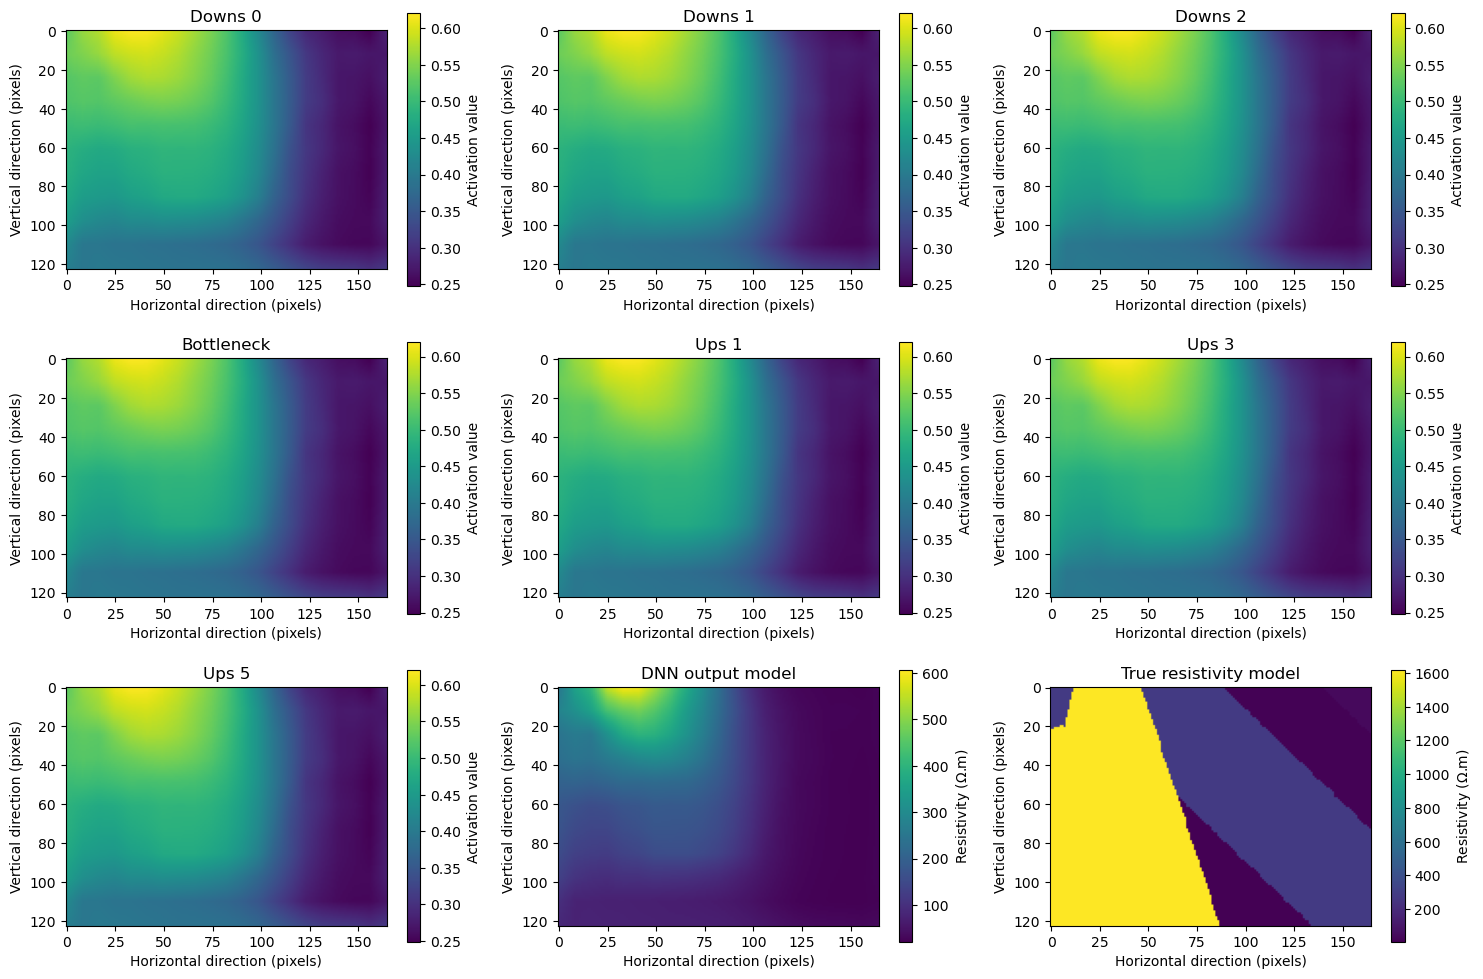

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
im0 = axes[0, 0].imshow(activation['downs.0.double_conv'].squeeze().numpy(), cmap='viridis')
axes[0, 0].set_title("Downs 0")
axes[0, 0].set_xlabel("Horizontal direction (pixels)")
axes[0, 0].set_ylabel("Vertical direction (pixels)")
cbar0 = fig.colorbar(im0, ax=axes[0, 0], orientation='vertical')
cbar0.set_label("Activation value")
im1 = axes[0, 1].imshow(activation['downs.0.double_conv.1'].squeeze().numpy(), cmap='viridis')
axes[0, 1].set_title("Downs 1")
axes[0, 1].set_xlabel("Horizontal direction (pixels)")
axes[0, 1].set_ylabel("Vertical direction (pixels)")
cbar1 = fig.colorbar(im1, ax=axes[0, 1], orientation='vertical')
cbar1.set_label("Activation value")
im2 = axes[0, 2].imshow(activation['downs.0.double_conv.2'].squeeze().numpy(), cmap='viridis')
axes[0, 2].set_title("Downs 2")
axes[0, 2].set_xlabel("Horizontal direction (pixels)")
axes[0, 2].set_ylabel("Vertical direction (pixels)")
cbar2 = fig.colorbar(im2, ax=axes[0, 2], orientation='vertical')
cbar2.set_label("Activation value")
im3 = axes[1, 0].imshow(activation['bottleneck.double_conv.5'].squeeze().numpy(), cmap='viridis')
axes[1, 0].set_title("Bottleneck")
axes[1, 0].set_xlabel("Horizontal direction (pixels)")
axes[1, 0].set_ylabel("Vertical direction (pixels)")
cbar3 = fig.colorbar(im3, ax=axes[1, 0], orientation='vertical')
cbar3.set_label("Activation value")
im4 = axes[1, 1].imshow(activation['ups.1.double_conv.5'].squeeze().numpy(), cmap='viridis')
axes[1, 1].set_title("Ups 1")   
axes[1, 1].set_xlabel("Horizontal direction (pixels)")
axes[1, 1].set_ylabel("Vertical direction (pixels)")
cbar4 = fig.colorbar(im4, ax=axes[1, 1], orientation='vertical')
cbar4.set_label("Activation value")
im5 = axes[1, 2].imshow(activation['ups.3.double_conv.5'].squeeze().numpy(), cmap='viridis')
axes[1, 2].set_title("Ups 3")
axes[1, 2].set_xlabel("Horizontal direction (pixels)")
axes[1, 2].set_ylabel("Vertical direction (pixels)")
cbar5 = fig.colorbar(im5, ax=axes[1, 2], orientation='vertical')
cbar5.set_label("Activation value")
im6 = axes[2, 0].imshow(activation['ups.5.double_conv.5'].squeeze().numpy(), cmap='viridis')
axes[2, 0].set_title("Ups 5")
axes[2, 0].set_xlabel("Horizontal direction (pixels)")
axes[2, 0].set_ylabel("Vertical direction (pixels)")
cbar6 = fig.colorbar(im6, ax=axes[2, 0], orientation='vertical')
cbar6.set_label("Activation value")
im7 = axes[2, 1].imshow(dnn_resistivity_model, cmap='viridis')
axes[2, 1].set_title("DNN output model")
axes[2, 1].set_xlabel("Horizontal direction (pixels)")
axes[2, 1].set_ylabel("Vertical direction (pixels)")
cbar7 = fig.colorbar(im7, ax=axes[2, 1], orientation='vertical')
cbar7.set_label(r"Resistivity ($\Omega$.m)")
im8 = axes[2, 2].imshow(true_resistivity_model, cmap='viridis')
axes[2, 2].set_title("True resistivity model")
axes[2, 2].set_xlabel("Horizontal direction (pixels)")
axes[2, 2].set_ylabel("Vertical direction (pixels)")
cbar8 = fig.colorbar(im8, ax=axes[2, 2], orientation='vertical')
cbar8.set_label(r"Resistivity ($\Omega$.m)")
plt.tight_layout()
plt.show()